### CARPENTER Algorithm: Closed Pattern Discovery by Transposing Tables

### Course Project - Data Mining and Data Warehousing

### **Team Members:**
#### **- Member 1:Momina Eman 221106**
  Data Preprocessing & Input Handling
#### **- Member 2: Esham Afzal 221008**
CARPENTER Algorithm Core Implementation  
#### **- Member 3: Ayesha Muniir 2210**
Visualization & Analysis

### Project Overview

This notebook demonstrates the CARPENTER algorithm, an efficient method for discovering closed frequent itemsets from transactional databases.


## Member 1: Data Preprocessing & Input Handling

### 1. Import all libraries & modules

In [18]:
# Import necessary libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import warnings
warnings.filterwarnings('ignore')

# Add src directory to path
sys.path.append(os.path.abspath('../src'))

# Import custom modules
from data_preprocessing import DataLoader, create_sample_dataset
from carpenter_algorithm import CARPENTER


print("All libraries imported successfully!")
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

All libraries imported successfully!
Python version: 3.13.9 (tags/v3.13.9:8183fa5, Oct 14 2025, 14:09:13) [MSC v.1944 64 bit (AMD64)]
NumPy version: 2.4.0
Pandas version: 2.3.3


### 2. Load Groceries dataset

In [19]:
# Load Groceries dataset
df = pd.read_csv('../data/raw/Groceries_dataset.csv', encoding='ISO-8859-1')

# Preview
print(df.head())
print(f"\nLoaded {len(df)} records")
print(f"Columns: {df.columns.tolist()}")

   Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk

Loaded 38765 records
Columns: ['Member_number', 'Date', 'itemDescription']


In [20]:
# Group items by Member_number and Date to create transactions
df['Transaction_ID'] = df['Member_number'].astype(str) + '_' + df['Date'].astype(str)

# Convert to transaction format: list of sets
transactions_dict = df.groupby('Transaction_ID')['itemDescription'].apply(set).to_dict()
transactions = list(transactions_dict.values())

print(f"Transformed {len(df)} records into {len(transactions)} transactions")
print(f"\nFirst 5 transactions:")
for i, trans in enumerate(transactions[:5], 1):
    print(f"  T{i}: {sorted(list(trans)[:5])}{'...' if len(trans) > 5 else ''}")
    
print(f"\nTransaction Statistics:")
print(f"  Total Transactions: {len(transactions)}")
print(f"  Unique Items: {df['itemDescription'].nunique()}")
print(f"  Avg Items per Transaction: {df.groupby('Transaction_ID').size().mean():.2f}")

Transformed 38765 records into 14963 transactions

First 5 transactions:
  T1: ['sausage', 'semi-finished bread', 'whole milk', 'yogurt']
  T2: ['pastry', 'salty snack', 'whole milk']
  T3: ['canned beer', 'misc. beverages']
  T4: ['hygiene articles', 'sausage']
  T5: ['pickled vegetables', 'soda']

Transaction Statistics:
  Total Transactions: 14963
  Unique Items: 167
  Avg Items per Transaction: 2.59


In [21]:
# Group items by Member_number and Date to create transactions
df['Transaction_ID'] = df['Member_number'].astype(str) + '_' + df['Date'].astype(str)

# Convert to transaction format: list of sets
transactions_dict = df.groupby('Transaction_ID')['itemDescription'].apply(set).to_dict()
transactions = list(transactions_dict.values())

print(f"Transformed {len(df)} records into {len(transactions)} transactions")
print(f"\nFirst 5 transactions:")
for i, trans in enumerate(transactions[:5], 1):
    print(f"  T{i}: {sorted(list(trans)[:5])}{'...' if len(trans) > 5 else ''}")
    
print(f"\nTransaction Statistics:")
print(f"  Total Transactions: {len(transactions)}")
print(f"  Unique Items: {df['itemDescription'].nunique()}")
print(f"  Avg Items per Transaction: {df.groupby('Transaction_ID').size().mean():.2f}")

Transformed 38765 records into 14963 transactions

First 5 transactions:
  T1: ['sausage', 'semi-finished bread', 'whole milk', 'yogurt']
  T2: ['pastry', 'salty snack', 'whole milk']
  T3: ['canned beer', 'misc. beverages']
  T4: ['hygiene articles', 'sausage']
  T5: ['pickled vegetables', 'soda']

Transaction Statistics:
  Total Transactions: 14963
  Unique Items: 167
  Avg Items per Transaction: 2.59


In [22]:
# Initialize DataLoader with our transactions
loader = DataLoader()
loader.transactions = transactions  # Use our Groceries transactions

# Update items set (IMPORTANT!)
for trans in transactions:
    loader.items.update(trans)

# Preprocess the data
cleaned_transactions = loader.preprocess_data(
    remove_duplicates=True,
    min_transaction_length=2
)

# Display statistics
loader.print_statistics()

# Create transaction matrix (horizontal format)
matrix, item_list, trans_ids = loader.create_transaction_matrix()

print(f"\n✓ Transaction Matrix Created:")
print(f"  Shape: {matrix.shape} (transactions × items)")
print(f"  Transactions: {matrix.shape[0]}")
print(f"  Items: {matrix.shape[1]}")
print(f"\nSample of transaction matrix (first 5 transactions, first 10 items):")
print(pd.DataFrame(matrix[:5, :10], 
                   columns=item_list[:10],
                   index=[f"T{i}" for i in range(1, 6)]))

✓ Preprocessing: 14963 → 7950 transactions

DATASET STATISTICS
Total Transactions:     7950
Unique Items:           167
Avg Transaction Length: 3.03
Min Transaction Length: 2
Max Transaction Length: 10
Database Density:       0.0181

✓ Created transaction matrix: 7950 × 167

✓ Transaction Matrix Created:
  Shape: (7950, 167) (transactions × items)
  Transactions: 7950
  Items: 167

Sample of transaction matrix (first 5 transactions, first 10 items):
    Instant food products  UHT-milk  abrasive cleaner  artif. sweetener  \
T1                      0         0                 0                 0   
T2                      0         0                 0                 0   
T3                      0         0                 0                 0   
T4                      0         0                 0                 0   
T5                      0         0                 0                 0   

    baby cosmetics  bags  baking powder  bathroom cleaner  beef  berries  
T1               0  

In [23]:
# Transpose the table (vertical format) - Key step in CARPENTER!
transposed_matrix = loader.transpose_table(matrix)

print(f"  Transposed Matrix (Vertical):")
print(f"  Shape: {transposed_matrix.shape} (items × transactions)")
print(f"  Items: {transposed_matrix.shape[0]}")
print(f"  Transactions: {transposed_matrix.shape[1]}")
print(f"\nSample of transposed matrix (first 5 items, first 10 transactions):")
print(pd.DataFrame(transposed_matrix[:5, :10],
                   index=item_list[:5],
                   columns=[f"T{i}" for i in range(1, 11)]))

✓ Transposed: (7950, 167) → (167, 7950)
  Transposed Matrix (Vertical):
  Shape: (167, 7950) (items × transactions)
  Items: 167
  Transactions: 7950

Sample of transposed matrix (first 5 items, first 10 transactions):
                       T1  T2  T3  T4  T5  T6  T7  T8  T9  T10
Instant food products   0   0   0   0   0   0   0   0   0    0
UHT-milk                0   0   0   0   0   0   0   0   0    0
abrasive cleaner        0   0   0   0   0   0   0   0   0    0
artif. sweetener        0   0   0   0   0   0   0   0   0    0
baby cosmetics          0   0   0   0   0   0   0   0   0    0


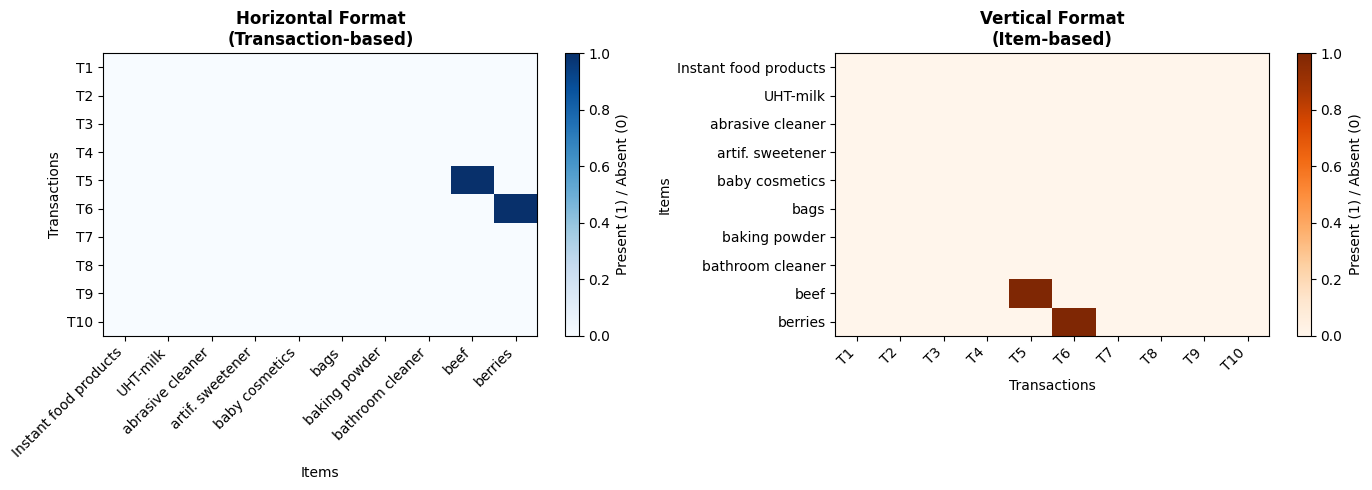

Both formats represent the same data, but vertical is more efficient for long databases


In [24]:
# Visualize the difference in representation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Horizontal format visualization
sample_horizontal = matrix[:10, :10]
im1 = ax1.imshow(sample_horizontal, cmap='Blues', aspect='auto')
ax1.set_title('Horizontal Format\n(Transaction-based)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Items')
ax1.set_ylabel('Transactions')
ax1.set_xticks(range(10))
ax1.set_xticklabels(item_list[:10], rotation=45, ha='right')
ax1.set_yticks(range(10))
ax1.set_yticklabels([f'T{i}' for i in range(1, 11)])
plt.colorbar(im1, ax=ax1, label='Present (1) / Absent (0)')

# Vertical format visualization
sample_vertical = transposed_matrix[:10, :10]
im2 = ax2.imshow(sample_vertical, cmap='Oranges', aspect='auto')
ax2.set_title('Vertical Format\n(Item-based)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Transactions')
ax2.set_ylabel('Items')
ax2.set_xticks(range(10))
ax2.set_xticklabels([f'T{i}' for i in range(1, 11)], rotation=45, ha='right')
ax2.set_yticks(range(10))
ax2.set_yticklabels(item_list[:10])
plt.colorbar(im2, ax=ax2, label='Present (1) / Absent (0)')

plt.tight_layout()
plt.show()

print("Both formats represent the same data, but vertical is more efficient for long databases")

In [25]:
miner = CARPENTER(minsup=0.05)   # adjust minsup if your teacher gave it
patterns = miner.mine_patterns(transactions)

print("Closed patterns found:", len(patterns))
for p in patterns[:20]:
    print(p.support, sorted(p.items))


Closed patterns found: 11
2363 ['whole milk']
1827 ['other vegetables']
1646 ['rolls/buns']
1453 ['soda']
1285 ['yogurt']
1041 ['root vegetables']
1014 ['tropical fruit']
908 ['bottled water']
903 ['sausage']
795 ['citrus fruit']
774 ['pastry']


In [26]:
from carpenter_algorithm import save_patterns_csv
save_patterns_csv(patterns, "results/carpenter_patterns.csv")


✓ Saved patterns to results/carpenter_patterns.csv (11 rows)
